In [13]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime

def visualize_Hypercolumn(mfr, n, FR):

    titles = [r'Vertical, $\theta=0°$', r'Horizontal, $\theta=90°$', r'ACW from vertical, $\theta=45°$', r'CW from vertical, $\theta=-45°$']
    nL = n**2
    
    for ii in range(4):
        
        a = asarray(mfr[nL*ii : nL*(ii+1)]/FR)
        b = a.reshape(n,n)
        
        plt.subplot(2,2,ii+1)
        plt.imshow(b,cmap='gray')
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])
    
n = 28
nL1 = nL2 = n**2
nL3 = nL1*4

[X,Y] = np.meshgrid(range(n), range(n))

taum = 10*ms
taui = 50*ms
taue = 100*ms

dge = 100*mV

duration = 500*ms

eqsPOISSON='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

mfr = np.zeros(5)

for qx in range(5):

        pat = np.zeros((28,28))
        
        if qx==0:
            pat[14, 13:16] = 1
        if qx==1:
            pat[13, 13] = 1
            pat[14, 14] = 1
            pat[15, 15] = 1
        if qx==2:
            pat[13:16, 14] = 1
        if qx==3:
            pat[13, 15] = 1
            pat[14, 14] = 1
            pat[15, 13] = 1
        if qx==4:
            pat[14, 13:16] = 1
        

        ############################################## Layer 1 ############################################################

        L1 = NeuronGroup(nL1,
                         eqsPOISSON,
                         threshold='rand()<rates*dt')

        L1.x = X.flatten()
        L1.y = Y.flatten()
        FR = 100*Hz
        L1.rates = pat.flatten()*FR

        ############################################## Layer 2 ############################################################

        L2 = NeuronGroup(nL2,
                         eqsLGN,
                         threshold = 'v>0.3*volt',
                         reset = 'v=0*volt',
                         refractory = 5*ms,
                         method = 'euler')

        L2.x = X.flatten()
        L2.y = Y.flatten()

        e1 = Synapses(L1, L2, on_pre='ge += dge')
        e1.connect(condition = 'i==j')

        i1 = Synapses(L1, L2, on_pre='gi -= 1/8*dge')
        i1.connect(condition = 'sqrt((x_pre-x_post)**2+(y_pre-y_post)**2)<2 and i!=j')

        ############################################## Layer 3 ############################################################

        L3 = NeuronGroup(nL3,
                         eqsV1,
                         threshold='v>0.3*volt',
                         reset='v=0*volt',
                         refractory=5*ms,
                         method='euler')

        L3.ori = np.repeat(np.array([0,1,2,3]), nL1)

        X3 = np.tile(X.flatten(), (1,4))
        X3.flatten()
        L3.x = X3.flatten()

        Y3 = np.tile(Y.flatten(), (1,4))
        Y3.flatten()
        L3.y = Y3.flatten()

        cond_range = 'abs(y_pre-y_post)<2 and abs(x_pre-x_post)<2 and ('

        cond_ver = 'ori_post==0 and x_pre==x_post or '
        cond_hor = 'ori_post==1 and y_pre==y_post or '
        cond_CW = 'ori_post==2 and abs(x_pre-x_post+y_pre-y_post)<1 or '
        cond_ACW = 'ori_post==3 and abs(x_pre-x_post-y_pre+y_post)<1)'
        condV1be = cond_range + cond_ver + cond_hor + cond_CW + cond_ACW

        cond_ver = 'ori_post==0 and x_pre!=x_post or '
        cond_hor = 'ori_post==1 and y_pre!=y_post or '
        cond_CW = 'ori_post==2 and abs(-x_pre+x_post+y_pre-y_post)>=1 or '
        cond_ACW = 'ori_post==3 and abs(x_pre-x_post+y_pre-y_post)>=1)'
        condV1bi = cond_range + cond_ver + cond_hor + cond_CW + cond_ACW

        e2 = Synapses(L2, L3, on_pre='ge += 1/3*dge')
        e2.connect(condition = condV1be)

        i2 = Synapses(L2, L3, on_pre='gi -= 1/6*dge')
        i2.connect(condition = condV1bi)

        sp3 = SpikeMonitor(L3)
        run(duration)
        MFR3 = sp3.count/duration
        a = asarray(MFR3[0:nL1])
        b = a.reshape(28,28)
        mfr[qx] = b[14,14]

## Case A) Vertical-Horizontal tuning curves

Text(0.5, 1.0, 'Tuning curve')

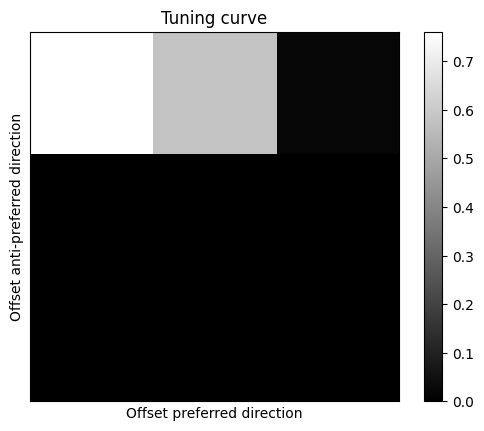

In [16]:
plt.imshow(mfr*Hz/FR,cmap='gray')
xlabel('Offset preferred direction')
ylabel('Offset anti-preferred direction')
xticks([])
yticks([])
colorbar()
title('Tuning curve')

## Case B) CW-ACW tuning curves

Text(0.5, 1.0, 'Tuning curve')

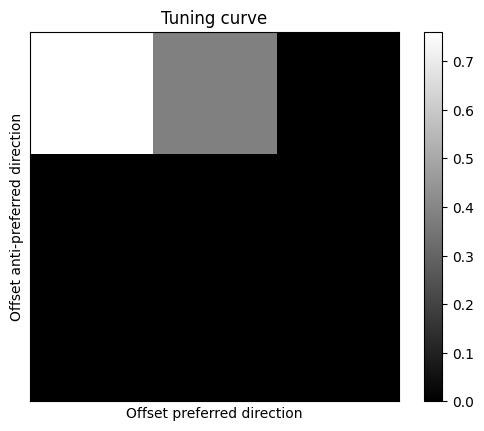

In [6]:
plt.imshow(mfr*Hz/FR,cmap='gray')
xlabel('Offset preferred direction')
ylabel('Offset anti-preferred direction')
xticks([])
yticks([])
colorbar()
title('Tuning curve')

## Case C) Orientation offset tuning curve

Text(0.5, 1.0, 'Tuning curve')

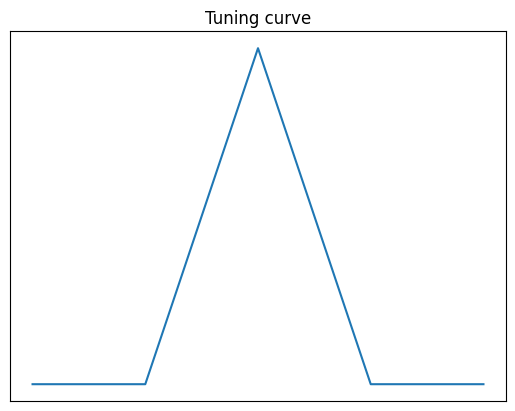

In [14]:
plot(mfr*Hz/FR)
xticks([])
yticks([])
title('Tuning curve')